Required dependencies qiskit, qiskit_ibm_runtime, pylatexenc

# Do the Hello World example on a 2-qubit Bell state


## Step 1: Map the problem to circuits and operators

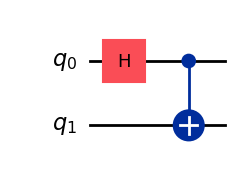

In [1]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt 

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output='mpl')


In [2]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX =  Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

## Step 2: Optimize

## Step 3: Execute on the backend

In [3]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.        ,  0.        ,  1.        , -0.00195312,
       -0.00195312]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0088484, 'sample_measure_time': 0.0016784, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 7517, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 1.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0088484, 'sample_measure_time': 0.0016784, 'input_qubi

## Step 4: Post-Processing (and plotting)

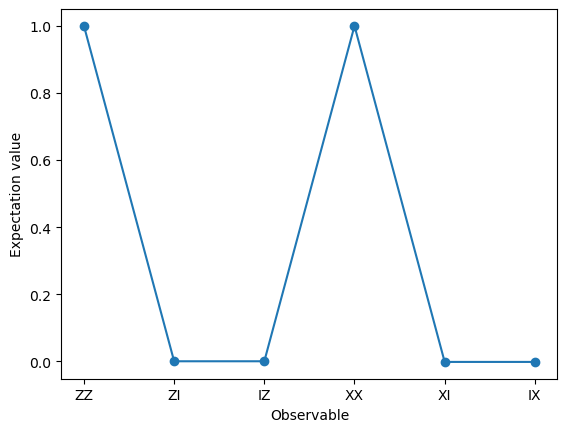

In [4]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']

# values = [job.result().get_estimation(observable) for observable in observables]
values = job.result().values

plt.plot(data, values, '-o')
plt.ylabel('Expectation value') 
plt.xlabel('Observable')
plt.show()    





## Extend the Hello World example to an $n$-qubit GHZ state, i.e., a state of the form $\frac{1}{\sqrt{2}}(|0\rangle^{\otimes n} + |1\rangle^{\otimes n})$. Compute the expectation value of the $Z^{\otimes n}$ operator.

## Step 1: Map the problem to cicuits and operators

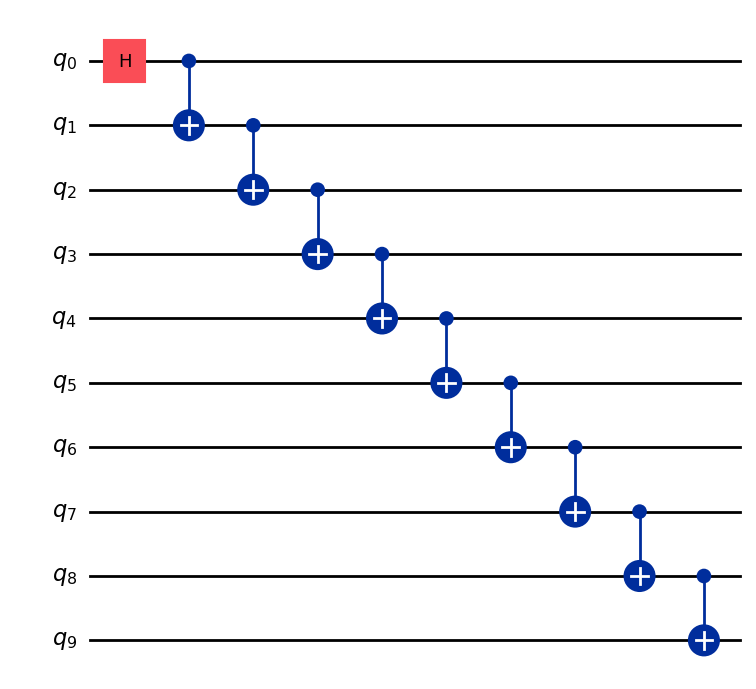

In [5]:
def get_qc_for_n_qubits_GHZ_states(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc

n = 10
qc = get_qc_for_n_qubits_GHZ_states(n)
qc.draw(output='mpl')

In [6]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n - i - 2) for i in range(n-1)]

print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(op) for op in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


n = 100 

## Step 2: Optimize the problem for quantum execution

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum",
                               token = "6ad185212aa0b001f9968d19fc8f2bc08813dc729540740067d0d73ab25b6528f6e855982ef376d2a2eabfa08bb85c313c94c26fedf8403e5c7b3f509cfb60c7")

In [ ]:
# QiskitRuntimeService.save_account(channel="ibm_quantum",
#                                   token = "6ad185212aa0b001f9968d19fc8f2bc08813dc729540740067d0d73ab25b6528f6e855982ef376d2a2eabfa08bb85c313c94c26fedf8403e5c7b3f509cfb60c7")

AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'

In [9]:
backend = service.backend(name="ibm_brisbane")

In [10]:
backend.num_qubits

127

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"

backend = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators] 

In [12]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options) 

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

cz45v2m10wx0008bd910


## Step 4: Post-process and plot

In [13]:
job_id = "cz45exk1xvhg008e53vg"

service = QiskitRuntimeService()
job = service.job(job_id)

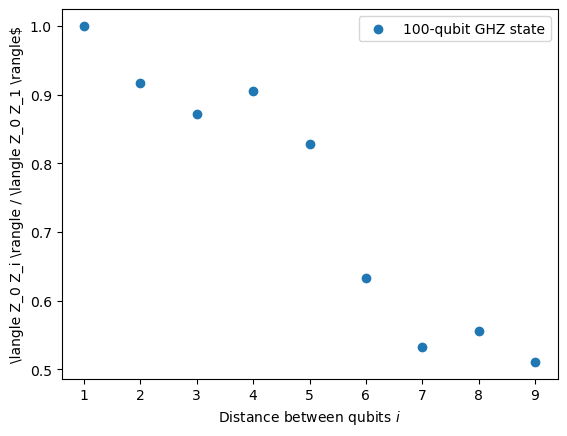

In [14]:
import matplotlib.pyplot as plt 

data = list(range(1, len(operators) + 1))
result = job.result()[0]
values = result.data.evs
values = [v/values[0] for v in values]

plt.scatter(data, values, marker = 'o', label = '100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()

